In [315]:
import os
os.chdir(r'D:\hft\portfolio-opt')
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cvxopt

In [316]:
#preset parameters
threshold=0.6
centrality=10

In [317]:
#get composites
df=pd.ExcelFile(r'D:\hft\portfolio-opt\euro50.xlsx').parse('composite price')
df.set_index('date',inplace=True)

In [318]:
#get stoxx50 index
sx5e=pd.ExcelFile(r'D:\hft\portfolio-opt\euro50.xlsx').parse('sx5e')
sx5e.set_index('Date',inplace=True)
sx5e.index=pd.to_datetime(sx5e.index)
sx5e.columns=['SX5E']

In [319]:
#get stoxx50 composites
components=df.columns.tolist()

In [320]:
#merge
metadata=df.merge(sx5e,left_index=True,right_index=True,how='inner')

&nbsp;
### In Sample
&nbsp;

In [321]:
#create graph adt
def create_graph(components,correlation,threshold):
    
    graph=nx.Graph()    
    
    #connect two vertices if correlation larger than the threshold
    for i in range(len(components)):
        for j in range(i+1,len(components)):
            if correlation.at[components[i],components[j]]>threshold:
                graph.add_edge(components[i],components[j],
                               weight=correlation.at[components[i],components[j]])
                graph.add_edge(components[j],components[i],
                               weight=correlation.at[components[i],components[j]])
    
    #fix layout for viz
    layout=nx.spring_layout(graph)
    
    return graph,layout

In [322]:
#take 60% for in sample data
data=metadata['2015':'2017'].copy()

#get percentage return
pctreturn=data.pct_change().dropna()

#get correlation
correlation=pctreturn[components].corr()

#pre-processing
graph,layout=create_graph(components,correlation,threshold)

&nbsp;
### Degeneracy Ordering
&nbsp;

In [323]:
#get independent vertex set
def degeneracy_ordering(graph,components):
    
    #degeneracy ordering
    degeneracy=dict(sorted(nx.core_number(graph).items(),
                           key=lambda x:x[1]))
        
    #create independent vertex set
    independence=[]
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)
        
    #add vertices not in graph
    leftout=[i for i in components if i not in graph.nodes]
    
    return independence,leftout

In [324]:
#find optimal threshold for correlation
def find_optimal_threshold(itr,data,components,correlation):
    
    optimal=[]
    for threshold_itr in itr:

        graph,_=create_graph(components,correlation,threshold_itr)        
        independence,leftout=degeneracy_ordering(graph,components)
        
        #compute sharpe ratio
        temp=data[leftout+independence].sum(axis=1).pct_change().dropna()
        optimal.append(temp.mean()/temp.std())
    
    #viz
    ax=plt.figure(figsize=(10,5)).add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.bar(np.arange(0.5,0.7,0.01),optimal,
            width=0.008,color='#F9CDAD')
    plt.title('Optimal Correlation')
    plt.xlabel('Correlation')
    plt.ylabel('Sharpe Ratio')
    plt.show()

In [347]:
#get independent vertex set
independence,leftout=degeneracy_ordering(graph,components)
data['degeneracy']=data[leftout+independence].sum(axis=1)

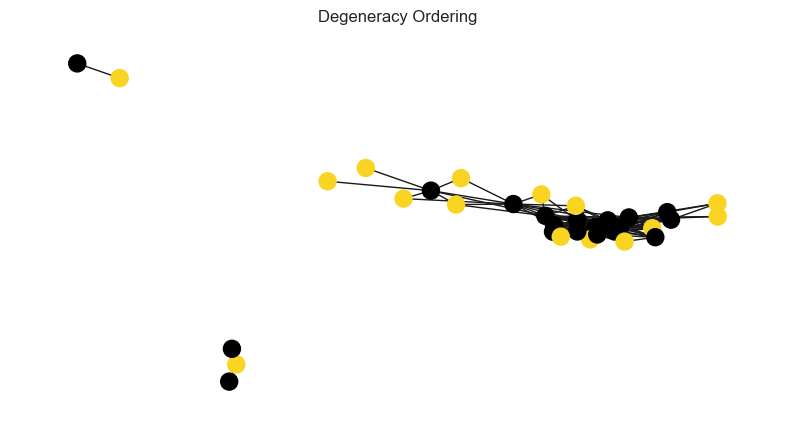

In [350]:
#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in independence:
        color.append('#000000')
    else:
        color.append('#F9D423')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Degeneracy Ordering')
plt.show()

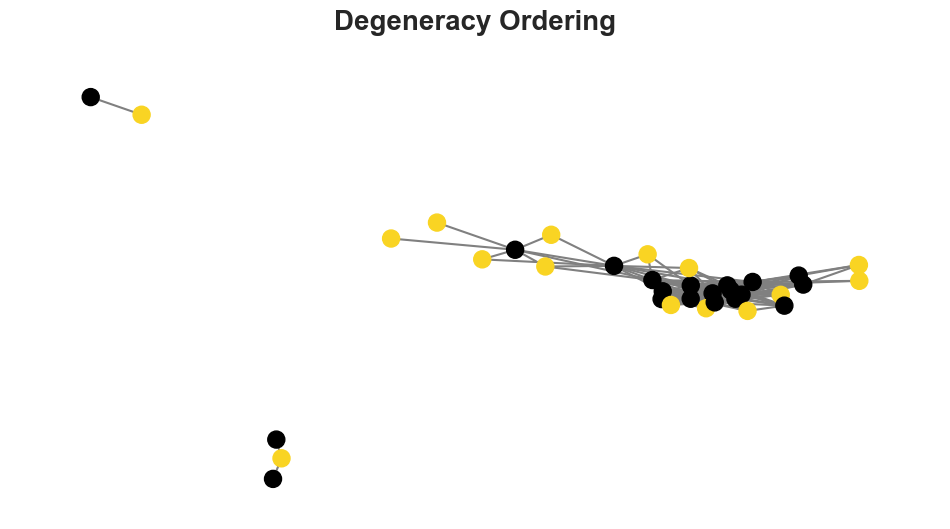

In [351]:
import matplotlib.pyplot as plt
import networkx as nx

#highlight selected vertices
color = ['#F9D423' if i in independence else '#000000' for i in graph.nodes]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Draw the graph
nx.draw(graph, pos=layout, node_color=color, node_size=150, ax=ax, width=1.5, edge_color='#808080', font_size=12, font_color='#333333', font_weight='bold')

# Set the title
ax.set_title('Degeneracy Ordering', fontsize=20, fontweight='bold', pad=20)

# Remove the axis lines
ax.axis('off')

# Display the plot
plt.show()


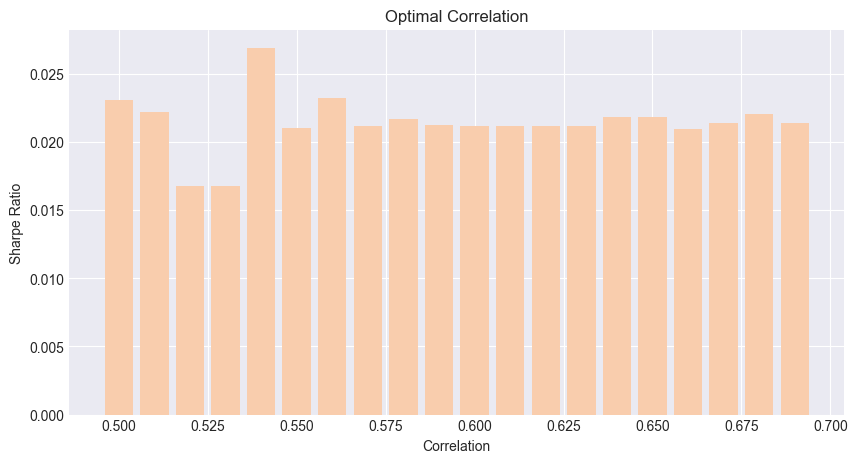

In [361]:
find_optimal_threshold(np.arange(0.5,0.7,0.01),
                       data,components,correlation)

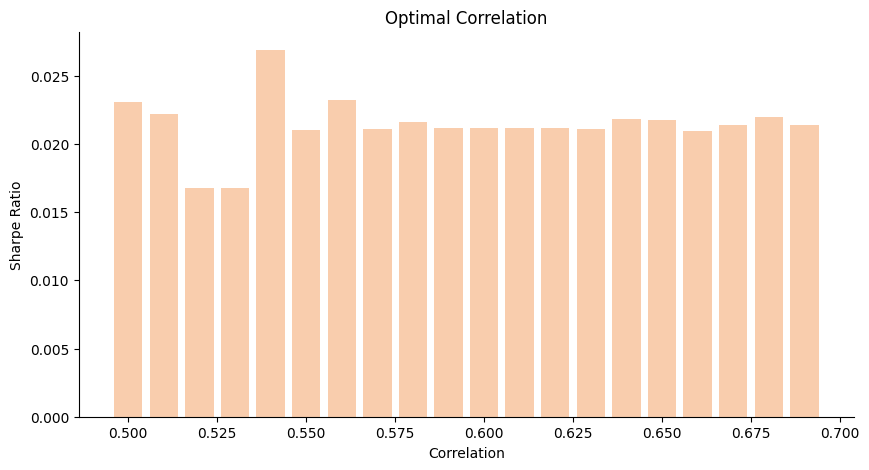

ValueError: x, y, and format string must not be None

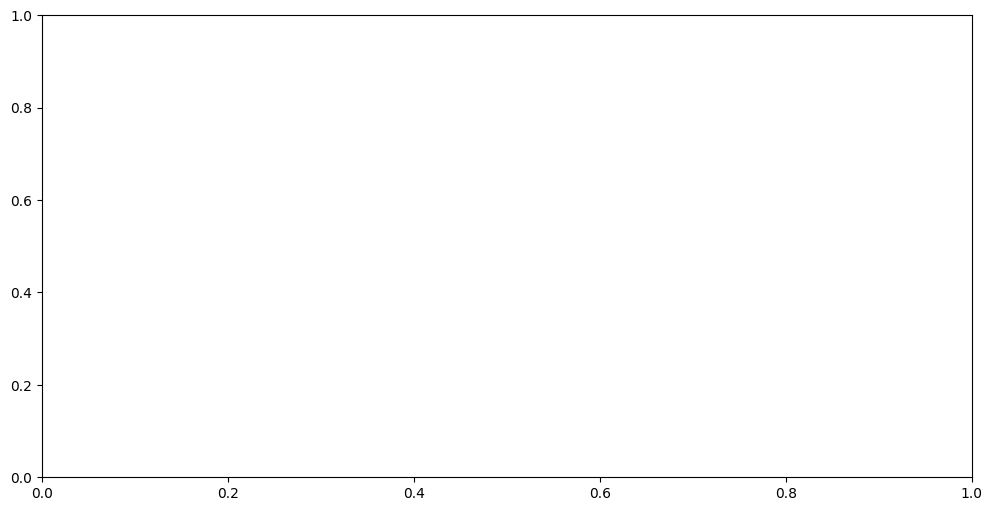

In [364]:
thresholds = np.arange(0.5, 0.7, 0.01)
optimal_thresholds = find_optimal_threshold(thresholds, data, components, correlation)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the threshold vs. performance
ax.plot(thresholds, optimal_thresholds, marker='o', color='#EC2049', linestyle='-', linewidth=3, markersize=10, markeredgecolor='#000000', markeredgewidth=1)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title and labels
ax.set_title('Optimal Correlation Threshold', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Threshold', fontsize=14, labelpad=15)
ax.set_ylabel('Performance', fontsize=14, labelpad=15)

# Customize the tick labels
ax.tick_params(axis='both', labelsize=12)

# Display the plot
plt.show()


&nbsp;
### Clique Centrality
&nbsp;

In [353]:
#use cross maximal clique centrality to construct the portfolio
def clique_centrality(graph,centrality):
    
    #compute cross maximal clique centrality
    cliques=list(nx.find_cliques(graph))

    D={}
    for ii in set([j for i in cliques for j in i]):
        D[ii]=[j for i in cliques for j in i].count(ii)

    #select vertices with centrality larger than the threshold
    clique_selected=[i[0] for i in D.items() if i[1]>centrality]
    
    return clique_selected

In [354]:
#find optimal threshold for correlation and centrality
def find_optimal_heat(itr1,itr2,data,components,correlation):
    
    #create dataframe for heatmap
    heat=pd.DataFrame(index=itr1)
    for i in itr2:
        heat[round(i,2)]=np.nan

    for threshold_itr in itr2:
        for centrality_itr in itr1:
            
            graph,_=create_graph(components,correlation,threshold_itr)        
            cliques=list(nx.find_cliques(graph))
            
            #efficient execution when no clique is found
            if cliques:
                
                #compute cross maximal clique centrality
                clique_selected=clique_centrality(graph,centrality_itr)
                
                #compute sharpe ratio
                temp=data[clique_selected].sum(axis=1).pct_change().dropna()
                heat.at[round(centrality_itr,2),
                        round(threshold_itr,2)]=temp.mean()/temp.std()
            else:
                pass
    
    #viz   
    heatmap(heat)

    
#create heatmap seaborn style
def heatmap(df,fig_size=(10,5),fontsize=0.8):
        
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)

    sns.set(font_scale=fontsize)
    
    #viz
    sns.heatmap(df,cmap=plt.cm.magma_r,
                robust=True,
                xticklabels=df.columns,
                yticklabels=df.index,
                ax=ax)
    
    #color bar title
    ax.collections[0].colorbar.set_label('Sharpe Ratio\n \n',rotation=270)
    
    plt.title('Optimal Correlation & Centrality')
    plt.xlabel('Correlation')
    plt.ylabel('Centrality')
    sns.set()
    
    plt.show()
    plt.style.use('default')

In [355]:
#use cross maximal clique centrality to construct the portfolio
clique_selected=clique_centrality(graph,centrality)
data['clique']=data[clique_selected].sum(axis=1)

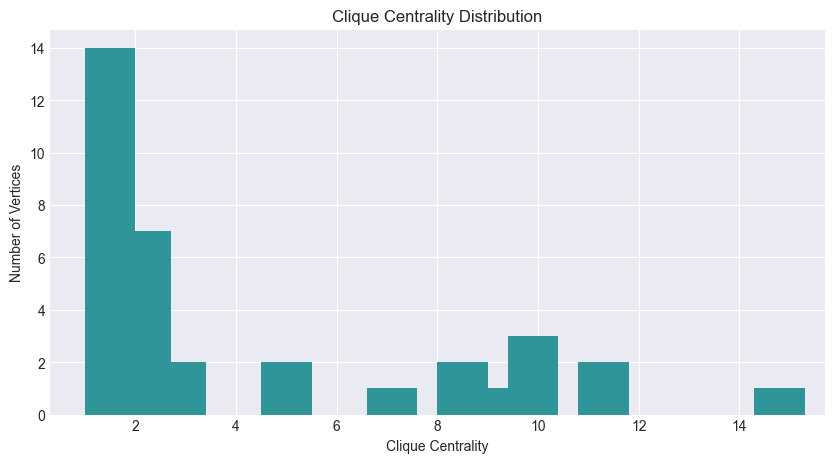

In [356]:
#viz clique centrality distribution
cliques=list(nx.find_cliques(graph))
dic={}
for ii in set([j for i in cliques for j in i]):
    dic[ii]=[j for i in cliques for j in i].count(ii)
        
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(dic.values(),width=1,bins=20,color='#2F9599')

plt.title('Clique Centrality Distribution')
plt.xlabel('Clique Centrality')
plt.ylabel('Number of Vertices')
plt.show()

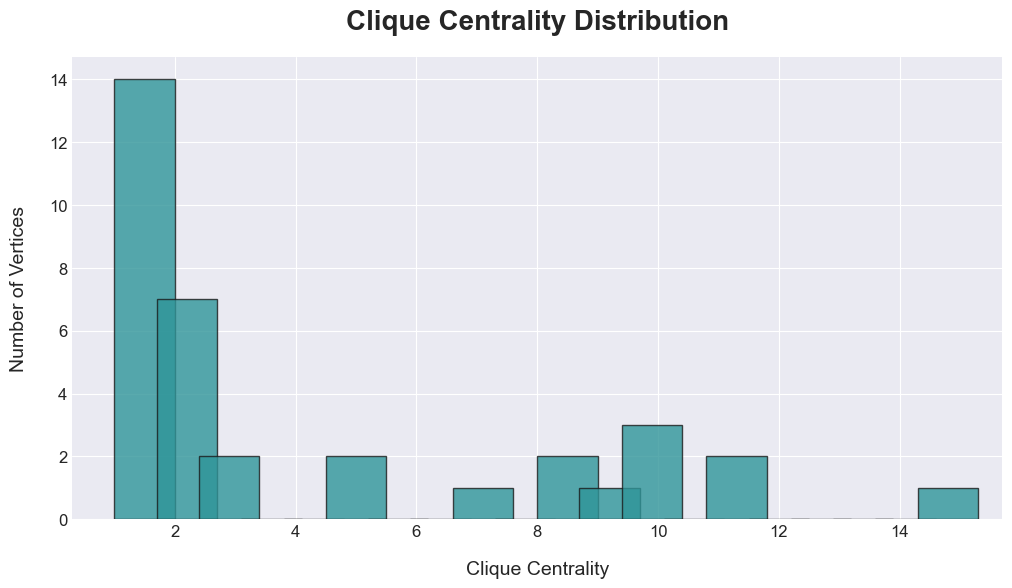

In [359]:
import matplotlib.pyplot as plt

# Create clique centrality distribution
cliques = list(nx.find_cliques(graph))
dic = {}
for ii in set([j for i in cliques for j in i]):
    dic[ii] = [j for i in cliques for j in i].count(ii)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the histogram
ax.hist(dic.values(), bins=20, width=1, color='#2F9599', edgecolor='#1A1A1A', alpha=0.8)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the title and labels
ax.set_title('Clique Centrality Distribution', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Clique Centrality', fontsize=14, labelpad=15)
ax.set_ylabel('Number of Vertices', fontsize=14, labelpad=15)

# Customize the tick labels
ax.tick_params(axis='both', labelsize=12)

# Display the plot
plt.show()


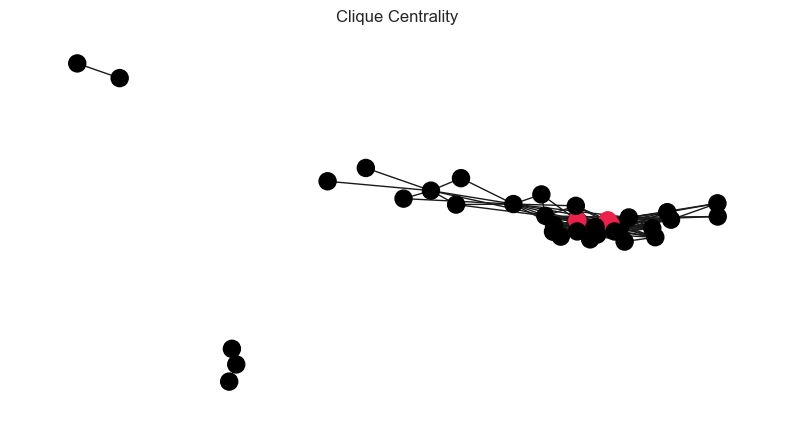

In [357]:
#highlight selected vertices
color=[]
for i in graph.nodes:
    if i not in clique_selected:
        color.append('#000000')
    else:
        color.append('#EC2049')

#viz graph
ax=plt.figure(figsize=(10,5)).add_subplot(111)
nx.draw(graph,node_color=color,pos=layout,node_size=150)
plt.title('Clique Centrality')
plt.show()

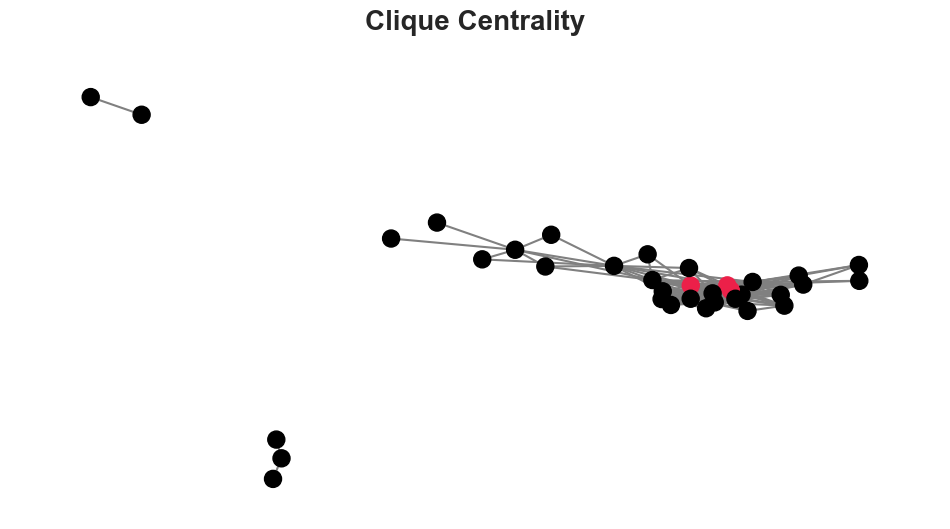

In [358]:
import matplotlib.pyplot as plt
import networkx as nx

#highlight selected vertices
color = ['#EC2049' if i in clique_selected else '#000000' for i in graph.nodes]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Draw the graph
nx.draw(graph, pos=layout, node_color=color, node_size=150, ax=ax, width=1.5, edge_color='#808080', font_size=12, font_color='#333333', font_weight='bold')

# Set the title
ax.set_title('Clique Centrality', fontsize=20, fontweight='bold', pad=20)

# Remove the axis lines
ax.axis('off')

# Display the plot
plt.show()


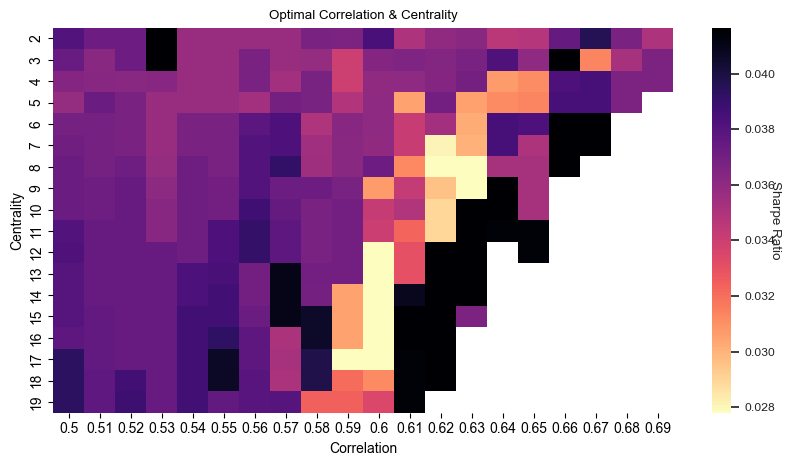

In [333]:
#viz optimal thresholds of correlation and centrality
find_optimal_heat(range(2,20),np.arange(0.5,0.7,0.01),
                  data,components,correlation)

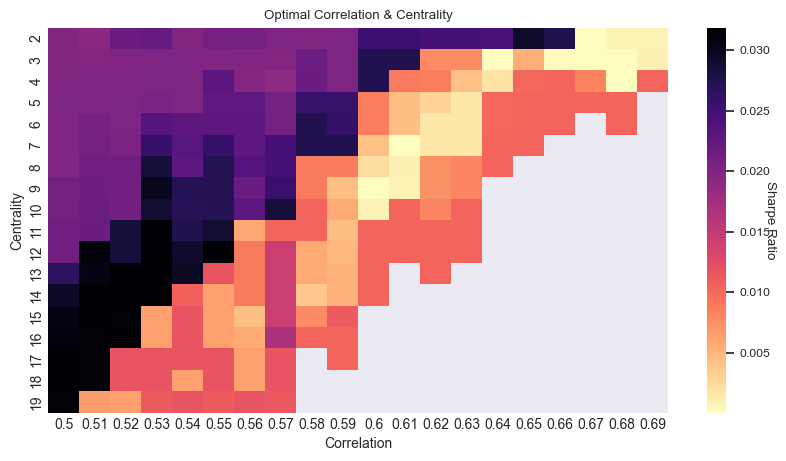

TypeError: Image data of dtype object cannot be converted to float

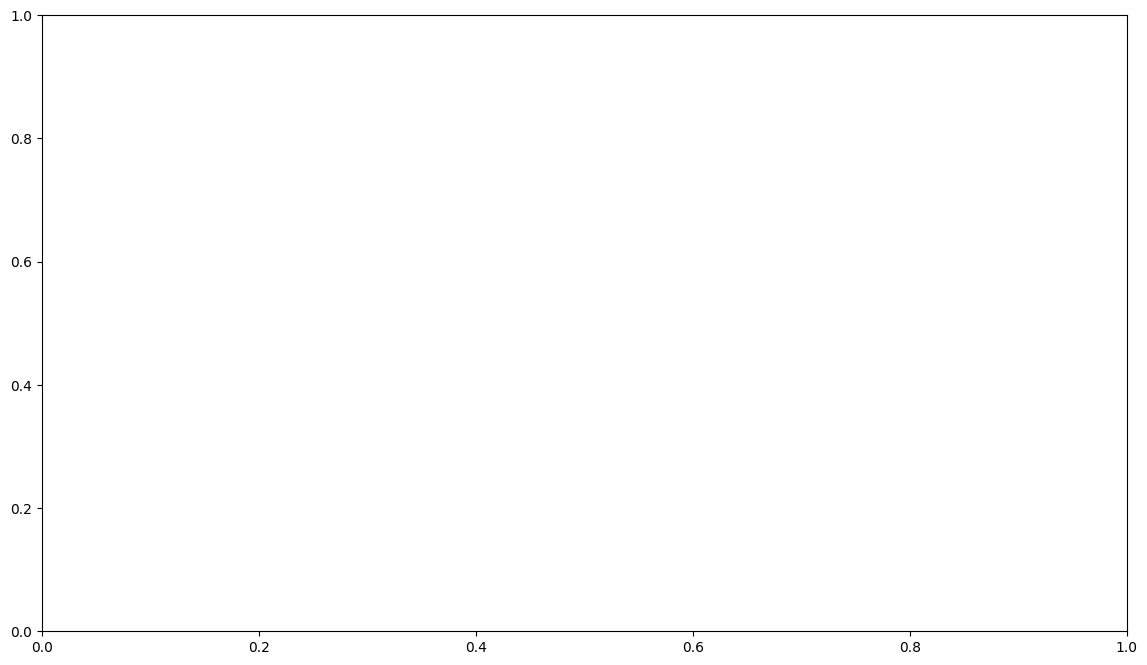

In [363]:
centrality_range = range(2, 20)
threshold_range = np.arange(0.5, 0.7, 0.01)

heatmap_data = find_optimal_heat(centrality_range, threshold_range, data, components, correlation)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the heatmap
heatmap = ax.imshow(heatmap_data, cmap='coolwarm', aspect='auto')

# Set the title and labels
ax.set_title('Optimal Thresholds of Correlation and Centrality', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Threshold', fontsize=14, labelpad=15)
ax.set_ylabel('Centrality', fontsize=14, labelpad=15)

# Customize the tick labels
ax.set_xticks(range(len(threshold_range)))
ax.set_xticklabels(np.round(threshold_range, 2), fontsize=12)
ax.set_yticks(range(len(centrality_range)))
ax.set_yticklabels(centrality_range, fontsize=12)

# Add a color bar
cbar = fig.colorbar(heatmap, ax=ax)
cbar.ax.tick_params(labelsize=12)

# Display the plot
plt.show()


&nbsp;
### Markowitz Optimization
&nbsp;

Using linear program with random cost, you can see details at the documentation of CVXOPT.

http://cvxopt.org/userguide/coneprog.html#quadratic-programming

&nbsp;

In [334]:
#find global maximum
def markowitz_optimization(pctreturn,components):

    #hide progress output
    cvxopt.solvers.options['show_progress']=False

    #create covariance matrix
    covariance=cvxopt.matrix(np.cov(np.array(pctreturn[components].T)))

    #number of assets
    assets=len(components)

    #realized return
    mean_return=cvxopt.matrix(pctreturn[components].mean(axis=0))

    #all weights should be larger than 0
    inequality_coeff=cvxopt.matrix(0.0,(assets,assets))
    inequality_coeff[::assets+1]=-1.0
    inequality_value=cvxopt.matrix(0.0,(assets,1))

    #sum of all weights equal to one
    equality_coeff=cvxopt.matrix(1.0,(1,assets))
    equality_value=cvxopt.matrix(1.0)

    #risk aversion parameter
    miu=1

    #maximize sharpe ratio
    max_sharpe=cvxopt.solvers.qp(P=cvxopt.matrix(miu*covariance),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']

    #minimize standard deviation
    min_variance=cvxopt.solvers.qp(P=cvxopt.matrix(covariance), 
                           q=cvxopt.matrix(0.0,(assets,1)),
                           G=inequality_coeff, 
                           h=inequality_value, 
                           A=equality_coeff, 
                           b=equality_value)['x']

    #maximize realized return
    max_return=cvxopt.solvers.qp(P=cvxopt.matrix(0.0,(assets,assets)),
                                 q=-mean_return,
                                 G=inequality_coeff,
                                 h=inequality_value,
                                 A=equality_coeff,
                                 b=equality_value)['x']
    
    return (max_sharpe,min_variance,max_return)

In [335]:
#markowitz portfolio optimization
max_sharpe,min_variance,max_return=markowitz_optimization(pctreturn,components)
data['sharpe']=np.dot(np.mat(data[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data['variance']=np.dot(np.mat(data[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data['return']=np.dot(np.mat(data[components]),np.mat(max_return)).reshape(-1,).tolist()[0]

#create equal weight index
data['equal']=data[components].sum(axis=1)

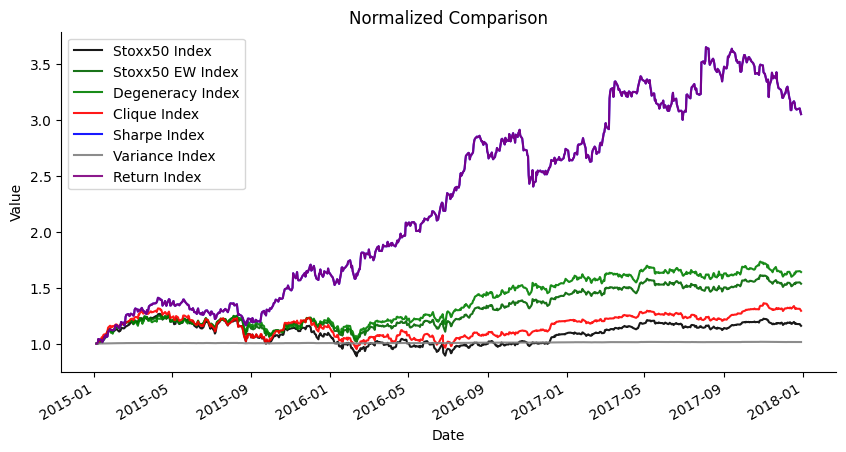

In [336]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data['SX5E']/data['SX5E'].iloc[0]).plot(label='Stoxx50 Index',alpha=0.9,color='black')
(data['equal']/data['equal'].iloc[0]).plot(label='Stoxx50 EW Index',alpha=0.9,color='darkgreen')
(data['degeneracy']/data['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.9,color='green')
(data['clique']/data['clique'].iloc[0]).plot(label='Clique Index',alpha=0.9,color='red')
(data['sharpe']/data['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.9,color='blue')
(data['variance']/data['variance'].iloc[0]).plot(label='Variance Index',alpha=0.9,color='grey')
(data['return']/data['return'].iloc[0]).plot(label='Return Index',alpha=0.9,color='purple')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

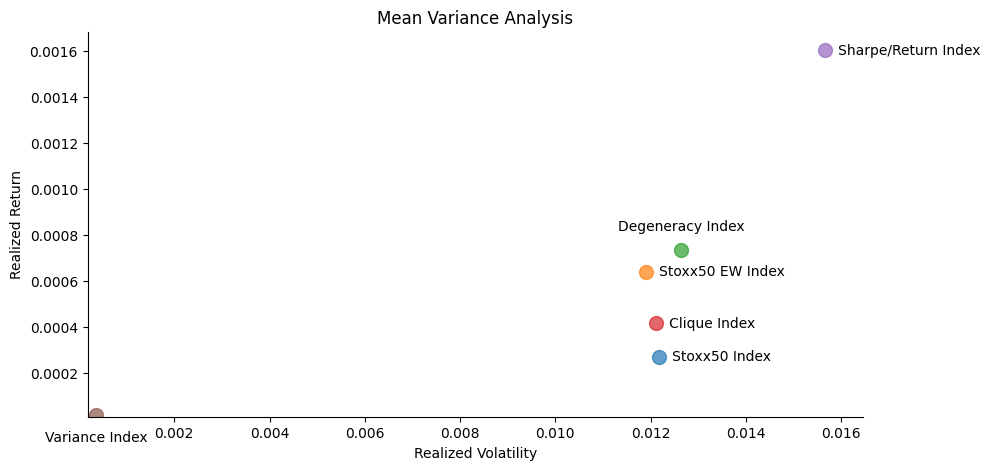

In [337]:
#mean variance analysis
comparison={}

for i in ['SX5E','equal','degeneracy','clique','sharpe','variance','return']:
    comparison[i]=(data[i].pct_change().dropna().std(), 
          data[i].pct_change().dropna().mean())
    
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter(comparison['SX5E'][0],comparison['SX5E'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Stoxx50 Index', xy=(comparison['SX5E'][0],comparison['SX5E'][1]),
             ha='left',va='center')
plt.scatter(comparison['equal'][0],comparison['equal'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Stoxx50 EW Index', xy=(comparison['equal'][0],comparison['equal'][1]),
             ha='left',va='center')
plt.scatter(comparison['degeneracy'][0],comparison['degeneracy'][1],
            s=100,alpha=0.7)
plt.annotate(text='Degeneracy Index\n', xy=(comparison['degeneracy'][0],comparison['degeneracy'][1]),
             ha='center',va='bottom')
plt.scatter(comparison['clique'][0],comparison['clique'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Clique Index', xy=(comparison['clique'][0],comparison['clique'][1]),
             ha='left',va='center')
plt.scatter(comparison['sharpe'][0],comparison['sharpe'][1],
            s=100,alpha=0.7)
plt.annotate(text='   Sharpe/Return Index', xy=(comparison['sharpe'][0],comparison['sharpe'][1]),
             ha='left',va='center')
plt.scatter(comparison['variance'][0],comparison['variance'][1],
            s=100,alpha=0.7)
plt.annotate(text='\nVariance Index', xy=(comparison['variance'][0],comparison['variance'][1]),
             ha='center',va='top')

plt.xlim(min([i[0] for i in comparison.values()])*0.5, 
         max([i[0] for i in comparison.values()])*1.05)
plt.ylim(min([i[1] for i in comparison.values()])*0.5, 
         max([i[1] for i in comparison.values()])*1.05)
plt.title('Mean Variance Analysis')
plt.xlabel('Realized Volatility')
plt.ylabel('Realized Return')
plt.show()


&nbsp;
### Out of Sample
&nbsp;

In [338]:
#take 30% for outta sample data
data=metadata['2018':].copy()

#get percentage return
pctreturn=data.pct_change().dropna()

#get correlation
correlation=pctreturn[components].corr()

#pre-processing
graph,layout=create_graph(components,correlation,threshold)

In [339]:
#generate indices
data['degeneracy']=data[leftout+independence].sum(axis=1)
data['clique']=data[clique_selected].sum(axis=1)
data['sharpe']=np.dot(np.mat(data[components]),np.mat(max_sharpe)).reshape(-1,).tolist()[0]
data['variance']=np.dot(np.mat(data[components]),np.mat(min_variance)).reshape(-1,).tolist()[0]
data['return']=np.dot(np.mat(data[components]),np.mat(max_return)).reshape(-1,).tolist()[0]
data['equal']=data[components].sum(axis=1)

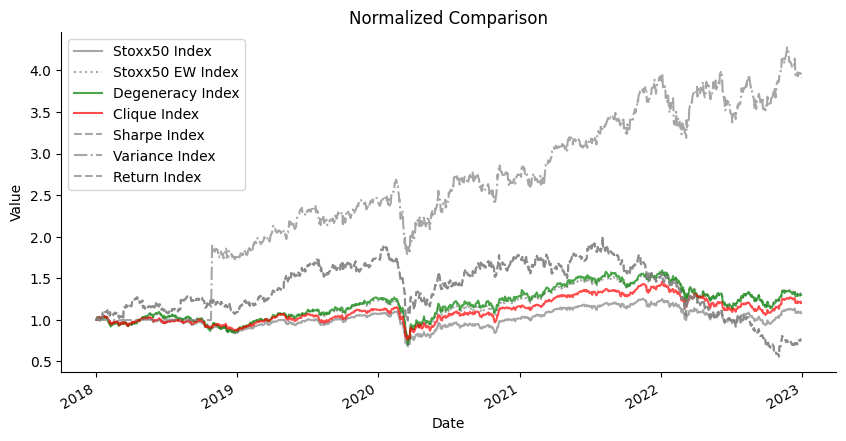

In [340]:
#normalized comparison
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(data['SX5E']/data['SX5E'].iloc[0]).plot(label='Stoxx50 Index',alpha=0.7,color='grey')
(data['equal']/data['equal'].iloc[0]).plot(label='Stoxx50 EW Index',alpha=0.7,color='grey',linestyle=':')
(data['degeneracy']/data['degeneracy'].iloc[0]).plot(label='Degeneracy Index',alpha=0.7,color='green')
(data['clique']/data['clique'].iloc[0]).plot(label='Clique Index',alpha=0.7,color='red')
(data['sharpe']/data['sharpe'].iloc[0]).plot(label='Sharpe Index',alpha=0.7,color='grey',linestyle='--')
(data['variance']/data['variance'].iloc[0]).plot(label='Variance Index',alpha=0.7,color='grey',linestyle='-.')
(data['return']/data['return'].iloc[0]).plot(label='Return Index',alpha=0.7,color='grey',linestyle='--')

plt.legend(loc=0)
plt.title('Normalized Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

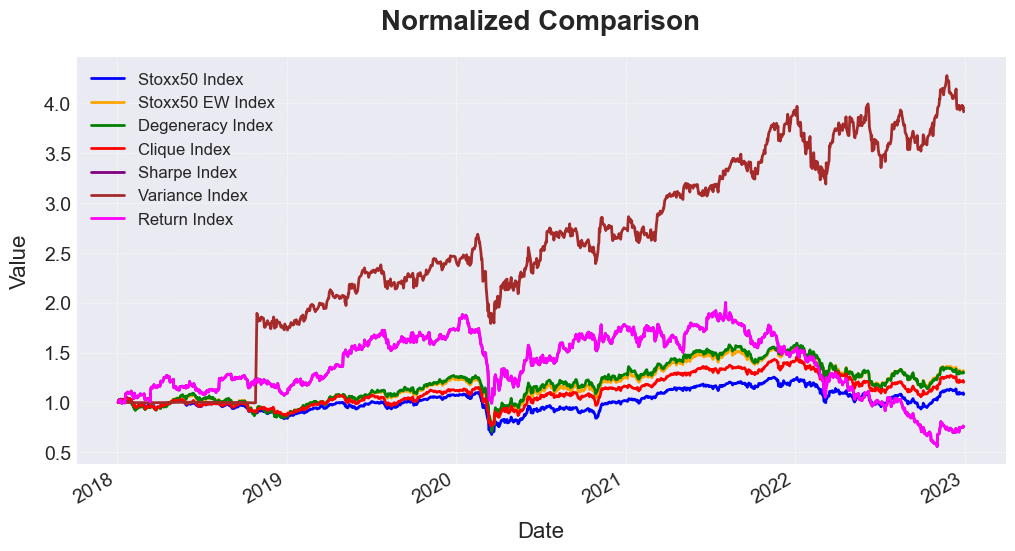

In [344]:
# Set style for the plot
plt.style.use('seaborn-darkgrid')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
(data['SX5E'] / data['SX5E'].iloc[0]).plot(ax=ax, label='Stoxx50 Index', lw=2, color='blue')
(data['equal'] / data['equal'].iloc[0]).plot(ax=ax, label='Stoxx50 EW Index', lw=2, color='orange')
(data['degeneracy'] / data['degeneracy'].iloc[0]).plot(ax=ax, label='Degeneracy Index', lw=2, color='green')
(data['clique'] / data['clique'].iloc[0]).plot(ax=ax, label='Clique Index', lw=2, color='red')
(data['sharpe'] / data['sharpe'].iloc[0]).plot(ax=ax, label='Sharpe Index', lw=2, color='purple')
(data['variance'] / data['variance'].iloc[0]).plot(ax=ax, label='Variance Index', lw=2, color='brown')
(data['return'] / data['return'].iloc[0]).plot(ax=ax, label='Return Index', lw=2, color='magenta')

# Set the title, labels, and legend
ax.set_title('Normalized Comparison', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=16, labelpad=10)
ax.set_ylabel('Value', fontsize=16, labelpad=10)
ax.legend(loc='upper left', fontsize=12)

# Customize the appearance of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(axis='both', labelsize=14)

# Add gridlines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.show()

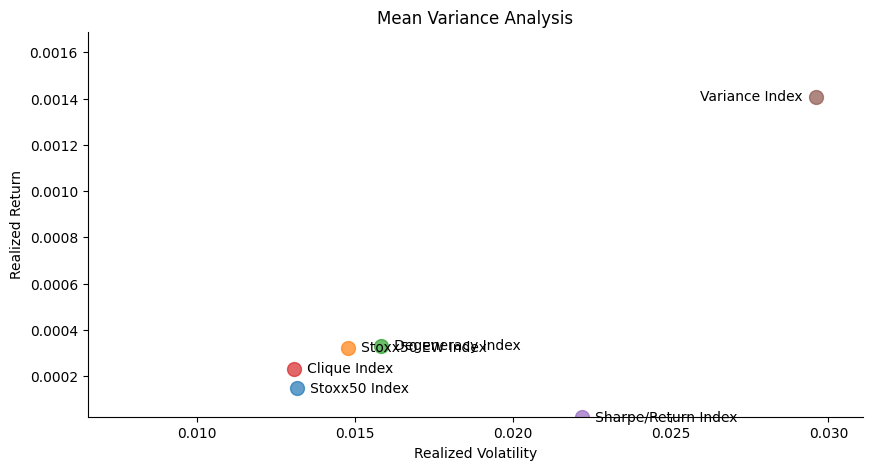

In [341]:
# mean variance analysis
comparison = {}

for i in ['SX5E', 'equal', 'degeneracy', 'clique', 'sharpe', 'variance', 'return']:
    comparison[i] = (
        data[i].pct_change().dropna().std(),
        data[i].pct_change().dropna().mean()
    )

# visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter(
    comparison['SX5E'][0], comparison['SX5E'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['SX5E'][0], comparison['SX5E'][1]),
    text='   Stoxx50 Index', ha='left', va='center'
)

ax.scatter(
    comparison['equal'][0], comparison['equal'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['equal'][0], comparison['equal'][1]),
    text='   Stoxx50 EW Index', ha='left', va='center'
)

ax.scatter(
    comparison['degeneracy'][0], comparison['degeneracy'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['degeneracy'][0], comparison['degeneracy'][1]),
    text='   Degeneracy Index', ha='left', va='center'
)

ax.scatter(
    comparison['clique'][0], comparison['clique'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['clique'][0], comparison['clique'][1]),
    text='   Clique Index', ha='left', va='center'
)

ax.scatter(
    comparison['sharpe'][0], comparison['sharpe'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['sharpe'][0], comparison['sharpe'][1]),
    text='   Sharpe/Return Index', ha='left', va='center'
)

ax.scatter(
    comparison['variance'][0], comparison['variance'][1],
    s=100, alpha=0.7
)
ax.annotate(
    xy=(comparison['variance'][0], comparison['variance'][1]),
    text='Variance Index   ', ha='right', va='center'
)

ax.set_xlim(
    min([i[0] for i in comparison.values()]) * 0.5, 
    max([i[0] for i in comparison.values()]) * 1.05
)

ax.set_ylim(
    min([i[1] for i in comparison.values()]) * 1.05, 
    max([i[1] for i in comparison.values()]) * 1.2
)

ax.set_title('Mean Variance Analysis')
ax.set_xlabel('Realized Volatility')
ax.set_ylabel('Realized Return')

plt.show()


In [342]:
pctreturn

,ADS.DE,AI.PA,AIR.PA,ALV.DE,AMS.MC,ABI.BR,ASML.AS,CS.PA,BBVA.MC,SAN.MC,...,SU.PA,SIE.DE,GLE.PA,TEF.MC,TTE.PA,UNA.AS,DG.PA,VIV.PA,VOW3.DE,SX5E
2018-01-04,0.013091,0.022792,0.020209,0.012953,0.021818,0.005542,0.011134,0.020623,0.017902,0.033547,...,0.018038,0.027301,0.024556,0.015797,0.019759,0.017177,0.025071,0.009565,0.017499,0.016810
2018-01-05,0.010573,0.008357,-0.002564,0.015652,0.027176,0.009434,0.013347,0.010499,0.004431,0.006563,...,0.013843,0.003844,0.014403,0.007595,0.007266,-0.012013,0.017997,0.014212,0.027287,0.010858
2018-01-08,0.004069,0.011050,0.011916,0.001511,-0.008504,-0.003360,0.012512,0.012155,-0.002482,0.002995,...,0.001638,0.007326,0.001331,0.001436,0.004391,-0.049868,0.001813,0.011465,0.003571,0.002445
2018-01-09,-0.020839,0.000911,0.003002,0.007996,0.011436,0.008640,-0.002602,0.008522,0.003732,0.001757,...,0.015267,0.004959,0.000886,0.000358,0.005517,0.009829,0.001810,0.041142,0.002224,0.001775
2018-01-10,-0.008572,-0.012284,0.039019,0.000748,-0.008166,-0.004805,-0.019563,0.013443,0.012118,0.024202,...,-0.009667,-0.009868,0.021140,-0.011824,-0.003106,-0.015243,-0.011066,0.001613,-0.011318,-0.003599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.005593,0.000449,-0.000894,-0.001728,-0.010852,-0.001407,-0.011285,-0.005456,0.004432,-0.005161,...,0.002599,-0.000156,0.008342,0.007445,0.003559,-0.000493,0.004586,0.000000,0.006790,-0.001643
2022-12-27,0.003814,0.001645,0.009665,0.004204,-0.009549,0.001233,-0.012768,0.002838,-0.003000,0.007156,...,0.009910,0.007624,0.002546,-0.002365,0.007093,-0.000397,-0.002548,-0.005593,0.001729,0.004160
2022-12-28,-0.004432,-0.004182,-0.010636,-0.004432,0.010462,-0.001055,-0.016657,-0.005848,0.001062,-0.006039,...,-0.004982,-0.008493,-0.004655,0.003852,-0.004360,-0.000495,-0.004896,-0.001575,-0.007768,-0.006280
2022-12-29,0.020671,0.010048,0.003584,0.007668,0.000812,0.003346,0.029693,0.001898,0.008311,0.007148,...,0.012745,0.015730,0.004252,0.017119,0.000168,-0.000523,0.008129,0.015547,0.010264,0.010830
